In [20]:
%matplotlib inline

import numpy as np
import control as ctl
from control.matlab import * 
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive
from scipy import signal, linalg
from labellines import labelLine # pip install matplotlib-label-lines
from sympy import Symbol, Matrix, simplify, mpmath, symbols
from sympy import integrate as Integrate, collect
from sympy import init_printing

# Note: in case of kernell crash when running control, update numpy

In [2]:
# set global plotting style
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

# plt.rc('font', **font)
plt.rcdefaults()

### Figure 1.6
Simulation of disk arm servo with analog (dashed) and computer control (solid). The sampling period is $h=0.2/\omega_0$.

In [3]:
freq = 1.
J = 8. # Moment of inertia of disk-drive
k = 3. # constant

a = 2.*freq
b = freq/2.
K = 2.*J*freq**2./k

G = ctl.tf([k],[J,0,0])
FB = K*ctl.tf([1, b], [1, a])
loop = ctl.feedback(G,FB,sign=-1)

gain = b*K/a
uc = 1.

In [4]:
dt = 0.01
t_in = np.arange(0,10,dt)
u = np.ones(len(t_in))*gain

t_out, y_out, _ = ctl.forced_response(loop, t_in, u)
_, e_out, _ = ctl.forced_response(FB, t_in, y_out)
error = u - e_out

In [5]:

    
def plot_discrete(h):
    fig1, axs = plt.subplots(num=1,nrows=2, ncols=1, figsize=(9,7))
    axs = np.asarray(axs).reshape(-1)
    loop_d = loop.sample(h)
    FB_d = FB.sample(h)

    td_in = np.arange(0,10,h)
    ud = np.ones(len(td_in))*gain

    td_out, yd_out, _ = ctl.forced_response(loop_d, td_in, ud)
    yd_out = yd_out[0] # discrete systems are stored as an array 
    _, ed_out, _ = ctl.forced_response(FB_d, td_in, yd_out)
    errord = ud - ed_out[0]
    fig1.show()
    
    # plot lti
    axs[0].step(t_out,y_out, color='blue')
    axs[1].step(t_out,error, color='blue')
    # plot discrete
    axs[0].step(td_out,yd_out, color='red')
    axs[1].step(td_out,errord, color='red')
    plt.show()
    
interactive_plot = interactive(plot_discrete, h=(0.1, 1.0))
interactive_plot

### Figure 1.8

# QUESTION ---------------------------------
In deze afbeelding zijn alle resultaten stabiel. 
Als ik de opgave goed begrijp is het doel om te laten zien dat als je een systeem gewoon sampelt hij instabiel word vanaf een bepaalde sampling constant. 
Zoals ik het in de afbeelding hieronder heb gedaan heb ik het systeem geconverteerd naar een discreet systeem door gebruik te maken van de sample functie, maar deze past ZOH toe. Dit is volgensmij niet de bedoeling. 
Je kunt de regels hieronder uncommenten om te zien hoe het systeem reageert als het gewoon gesampeld word zonder eerst zoh toe te passen. Maar dan zijn alle systemen zowiso onstabiel...

Ik heb de andere afbeeldingen van Chap 1. nog maar overgeslagen aangezien deze verder bouwen op dit systeem.

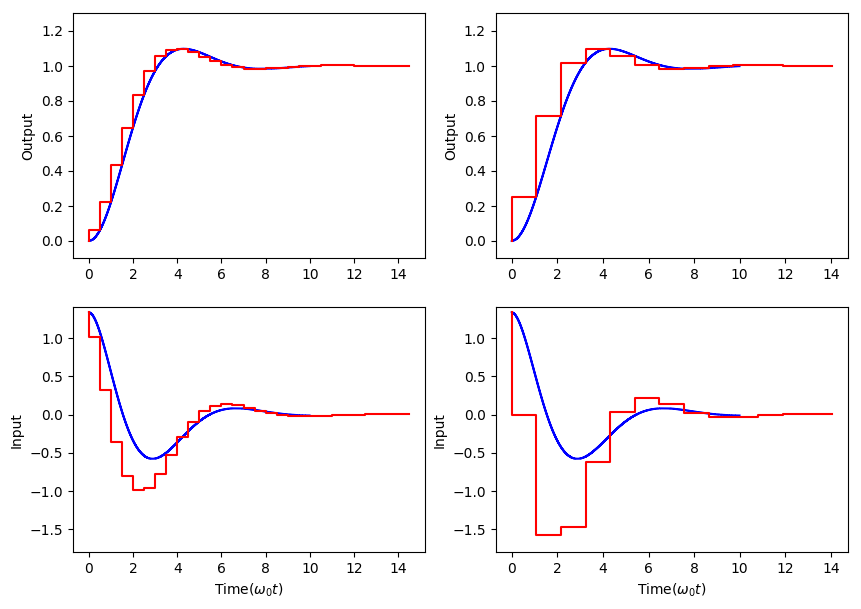

In [6]:
fig1, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,7))

h_range = [0.5, 1.08]
for i in range(2):
    h = h_range[i]/freq
    
    # ------- Switch between sampling (ZOH) and sampling the system
    loop_d = loop.sample(h)
#     loop_d = ctl.tf(loop.num[0][0],loop.den[0][0], h)
    FB_d = FB.sample(h)
#     FB_d = ctl.tf(FB.num[0][0],FB.den[0][0], h)

    td_in = np.arange(0,15,h)
    ud = np.ones(len(td_in))*gain

    td_out, yd_out, _ = ctl.forced_response(loop_d, td_in, ud)
    yd_out = yd_out[0] # discrete systems are stored as an array 
    _, ed_out, _ = ctl.forced_response(FB_d, td_in, yd_out)
    errord = ud - ed_out[0]
    
    # plot lti
    axs[0][i].step(t_out,y_out, color='blue')
    axs[0][i].set_ylabel('Output')
    axs[0][i].set_ylim((-0.1, 1.3))
    axs[1][i].step(t_out,error, color='blue')
    axs[1][i].set_ylabel('Input')
    axs[1][i].set_ylim((-1.8, 1.4))
    # plot discrete
    axs[0][i].step(td_out,yd_out, color='red')
    axs[0][i].set_ylabel('Output')   
    axs[0][i].set_ylim((-0.1, 1.3))
    axs[1][i].step(td_out,errord, color='red')
    axs[1][i].set_ylabel('Input')
    axs[1][i].set_xlabel('Time($\omega_0t$)')
    axs[1][i].set_ylim((-1.8, 1.4))
    
plt.show();

## Deadbeat-controller
### Figure 1.9

# Chapter 2

Consider the continuous-time system

$$
\frac{\omega_0^2}{s^2+2\zeta\omega_0s +\omega_0^2}
$$

The poles of the corresponding discrete-time system are given by the characteristic equation 

$$
z^2 + a_1z +a_2 = 0
$$
where 
$$
a_1 = -2e^{-\zeta\omega_0h}cos(\sqrt{1-\zeta^2}\omega_0h)\\
a_2 = e^{-2\zeta\omega_0h}
$$


#### Figure 2.7

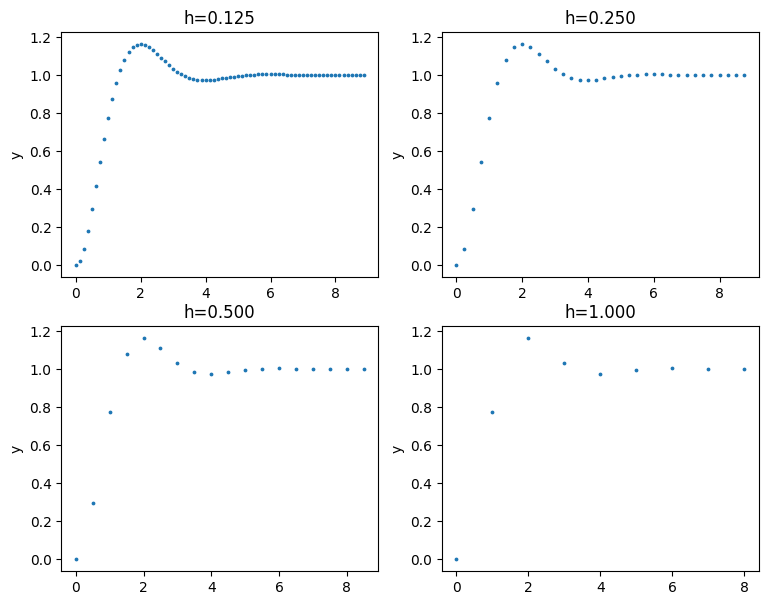

In [7]:
freq = 1.83
zeta = 0.5
h_range = [0.125, 0.25, 0.5, 1.0]

G = ctl.tf([freq**2], [1, 2*zeta*freq, freq**2])


fig1, axs = plt.subplots(nrows=2, ncols=2, figsize=(9,7))
axs = np.asarray(axs).reshape(-1)

for i in range(4):
    dt = h_range[i]
    G_d = G.sample(dt)
    t_in = np.arange(0,9,dt)
    _, _y_out = ctl.step_response(G_d, t_in)
    
    y_step = _y_out[0] # output is stored in tuple
    axs[i].scatter(t_in,y_step,3)
#     axs[i].grid()
#     axs[i].set_xlabel('t')
    axs[i].set_ylabel('y')
    axs[i].set_title('h=%.3f'%dt)
plt.show()

## Sampling a Continuous-Time State-Space System

Assume that the continuous-time system is given in the following state-space form:

$$
\frac{dx}{dt} = Ax(t) + Bu(t) \\
y(t) = Cx(t) + Du(t)
$$

A common situation in computer control is that the D-A converter is so constructed taht it holds the analog signal constant until a new conversion is commanded. This is often called a *zero-order-hold circuit*.

This can be expressed using the following mathematical equation:

$$
x(t_{k+1}) = \Phi(t_{k+1}, t_k)x(t_k) + \Gamma(t_{k+1},t_k)u(t_k) \\
y(t_k) = Cx(t_k) + Du(t_k)
$$

where

$$
\Phi(t_{k+1}, t_k) = e^{A(t_{k+1}-t_k)}\\
\Gamma(t_{k+1},t_k) = \int^{t_{k+1}t_k}_0e^{As}ds\ B
$$

The relationship between the sampled signals can be expressed by the linear difference equation shown above. notice that this equation does not involve any approximations. It gives the exact values of the state variables and the output at the sampling instants because the control signal is constant between the sampling instants. The model is therefore called a zero-roder-hold sampling of the system. \\
In most cases $D=0$. One reason for this is because in computer-controlled systems, the output y is first measured and the control signal $u(t_k)$ is then generated as a function of $y(t_k)$. In practice it often happens that there is a significant delay between the A-D and D-A conversions. However it is easy to make the necessary modifications. The state vector at times between sampling points is given by $x(t_{k+1})$. This makes it possible to investigate the intersample behavior of the system. Notice that the responses between the sampling points are parts of step respones, with initial conditions, for the system. This implies that the system is running in open loop between the sampling points.\\
For periodic sampling with period h, we have $t_k=k\cdoth and the model given above simplifies to the time-invariant system:

$$
x(kh+h) = \Phi (kh) + \Gamma (kh) \\
y(kh) = Cx(kh) + Du(kh)
$$

where 

$$
\Phi = e^{Ah} \\
\Gamma = \int_0^h e^{As}ds\ B
$$

From this it follows that

$$
\frac{d\Phi(t)}{dt}= A\Phi(t) = \Phi(t)A \\
\frac{d\Gamma(t)}{dt} = \Phi(t)B
$$

The matrices $\Phi$ and $\Gamma$ therefore satisfy the equation

$$
\frac{d}{dt} 
\begin{bmatrix}
\Phi(t) & \Gamma(t) \\
0 & I
\end{bmatrix}
=
\begin{bmatrix}
\Phi(t) & \Gamma(t) \\
0 & I
\end{bmatrix}
\begin{bmatrix}
A & B \\
0 & 0
\end{bmatrix}
$$
Where I is a unit matrix of the same dimension as the number of inputs. The matrices $\Phi(h)$ and $\Gamma(h)$ for the sampling period h therefore can be obtained from the block matrix:

$$
\begin{bmatrix}
\Phi(h) & \Gamma(h) \\
0 & I
\end{bmatrix}
=
exp(\begin{bmatrix}
A & B \\
0 & 0
\end{bmatrix}
h)
$$

## Python implementation

In [8]:
"""
This function calculates the Phi and Gamma values used for zero order hold and
the Pulse-Transfer operator.

@input A, B: state matrices
@input h: sampling period
@output Phi, Gamma
"""
def get_phi_gamma(A, B, h):
    # Using the formula shown above
    # create matrix [A B ;
    #                0 0]
    m_top = np.hstack((A, B)) # create top of matrix
    m_bottom = np.zeros(m_top.shape) # create bottom part
    m = np.vstack((m_top, m_bottom)) # combine top and bottom 
    expm = linalg.expm(m*h) # Equation 2.6 from the book
    
    # Dispose of the lower rows
    expm = expm[:A.shape[0], :]

    Phi = expm[:, 0:A.shape[1]]
    Gamma = expm[:, A.shape[1]:]
    return (Phi, Gamma)

def get_phi_gamma_sym(A, B):
    h = Symbol('h')
    s = Symbol('s')
    I = Matrix.eye(A.shape[0])
    A = Matrix(A)
    B = Matrix(B)
    
    # Equation 2.5 from the book
    Phi = Matrix.exp(A*h)
    Gamma = Integrate(Matrix.exp(A*s), (s, 0, h))*B
    return (Phi, Gamma)


"""
This function converts a continuous-time state space system into
a discrete system with sampling period h using zero order hold.

@input ss_sys: expects a tuple of (A, B, C, D)
@input h: sampling period
@output ss_d: a tuple of (A, B, C, D)
"""
def zoh(ss_sys, h):
    A, B, C, D = ss_sys
    Ad, Bd = get_phi_gamma(A, B, h)
    Cd = C
    Dd = D
    
    return (Ad, Bd, Cd, Dd)


### Example 2.2 Double integrator

The double integrator is described by

$$
\frac{dx}{dt} = 
\begin{bmatrix}
0 & 1 \\
0 & 0
\end{bmatrix}
x +
\begin{bmatrix}
0 \\
1
\end{bmatrix}
u \\
y = 
\begin{bmatrix}
1 & 0
\end{bmatrix}
x
$$

Hence

$$
\Phi = e^{Ah} = I +Ah+\frac{A^2h^2}{2} + \ldots =
\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
+
\begin{bmatrix}
0 & h \\
0 & 0
\end{bmatrix}
=
\begin{bmatrix}
1 & h \\
0 & 1
\end{bmatrix} \\
\Gamma = \int_0^h 
\begin{bmatrix}
s \\
1
\end{bmatrix}
ds
=
\begin{bmatrix}
\frac{h^2}{2} \\
h
\end{bmatrix}
$$

The discrete-time model of the double integrator is

$$
x(kh+h) = 
\begin{bmatrix}
1 & h \\
0 & 1
\end{bmatrix}
x(kh) +
\begin{bmatrix}
\frac{h^2}{2} \\
h
\end{bmatrix}
u(kh) \\
y(kh) = 
\begin{bmatrix}
1 & 0
\end{bmatrix}
x(kh)
$$

This can easily be done by the python function above:

In [9]:
# Example 2.2 (with parametrized mass)

h = 0.1
m = 30

A = np.array([[0, 1], [0, 0]])
B = np.array([[0, 0], [1./m, 0]])
C = np.array([[1, 0], [0, 0]])
D = np.array([[0, 0], [0, 0]])

Ad, Bd, Cd, Dd = zoh((A, B, C, D), h)
print("Ad="); print(Ad)
print("Bd="); print(Bd)
print("Cd="); print(Cd)

Ad=
[[1.  0.1]
 [0.  1. ]]
Bd=
[[0.00016667 0.        ]
 [0.00333333 0.        ]]
Cd=
[[1 0]
 [0 0]]


### The Pulse-Transfer Operator


$$
H(q) = C(qI-\Phi)^{-1}\Gamma + D = \frac{B(q)}{A(q)}
$$

In [10]:



def pulse_transfer(ss_sys, h):
    A, B, C, D = ss_sys
    q = Symbol('q')
    Phi, Gamma = get_phi_gamma(A, B, h)
    m_inv = Matrix(q*np.eye(Phi.shape[0])-Phi).inv()
    H = C*m_inv*Gamma
    return H


### Example 2.12

In [11]:
A = np.array([[0, 1], [0, 0]])
B = np.array([[0, 0], [1., 0]])
C = np.array([[1, 0], [0, 0]])

H = pulse_transfer((A,B,C,D), 1.)

q = Symbol('q')
ans = 0.5*(q**-1+q**-2)/(1-2*q**-1+q**-2) 
print(simplify(H[0]))
# Zero check
print(simplify(H[0]-ans))

0.5*(q + 1)/(1.0*q**2 - 2.0*q + 1.0)
0


### Complex poles

Consider the continuous-time system
$$
G = \frac{\omega^2}{s^2 + 2\zeta\omega_0s+\omega_0^2}
$$
The poles of the corresponding dicrete-time system are given by the characteristic equation:
$$
z^2+a_1z+a_2 = 0
$$
where
$$
a_1 = -2e^{-\zeta\omega_0h}cos(\sqrt{1-\zeta^2}\omega_0h) \\
a_2 = e^{-2\zeta\omega_0h}
$$

In [12]:
freq = 1.83
zeta = 0.5
h = 0.1

G = ctl.tf([freq**2], [1, 2*zeta*freq, freq**2])
print("Continuous-time system G: ")
print(G)
print("The poles of the corresponding discrete-time system: ")
a_1 = -2*np.exp(-zeta*freq*h)*np.cos(np.sqrt(1-zeta**2)*freq*h)
a_2 = np.exp(-2*zeta*freq*h)
print("z^2 + %.3fz + %.3f = 0 \n" % (a_1, a_2))

print("We can use the built in sample function to confirm our solution:")
print(G.sample(h))

Continuous-time system G: 

        3.349
--------------------
s^2 + 1.83 s + 3.349

The poles of the corresponding discrete-time system: 
z^2 + -1.802z + 0.833 = 0 

We can use the built in sample function to confirm our solution:

  0.01572 z + 0.01479
----------------------
z^2 - 1.802 z + 0.8328

dt = 0.1



In [13]:
h = 0.1
freq = 1.83
zeta = 0.5

G = ctl.tf([freq**2], [1, 2*zeta*freq, freq**2])
G_d = G.sample(3)

# calculate for constant damping
sampling_rates = np.arange(0.01,1.8,0.05)
dampings = np.arange(0, 1.1, 0.1)
poles_cd = np.zeros((len(dampings),len(sampling_rates)),dtype=np.complex_)

for i,zeta in enumerate(dampings): # loop over damping ratios
    G = ctl.tf([freq**2], [1, 2*zeta*freq, freq**2])
    for j,h in enumerate(sampling_rates): # loop over sampling rates
        G_d = G.sample(h)
        _poles, _ = ctl.pzmap(G_d, Plot=False)
        poles_cd[i,j] = _poles[0] # only store one pole
        
# calculate for constant sampling rate
sampling_rates = np.arange(0.2,1.8,.2)
_dampings = np.arange(0, 1.1, 0.01)
poles_cs = np.zeros((len(sampling_rates),len(_dampings)),dtype=np.complex_)

for i,zeta in enumerate(_dampings): # loop over damping ratios
    G = ctl.tf([freq**2], [1, 2*zeta*freq, freq**2])
    for j,h in enumerate(sampling_rates): # loop over sampling rates
        G_d = G.sample(h)
        _poles, _ = ctl.pzmap(G_d, Plot=False)
        poles_cs[j,i] = _poles[0] # only store one pole

### Figure 2.8

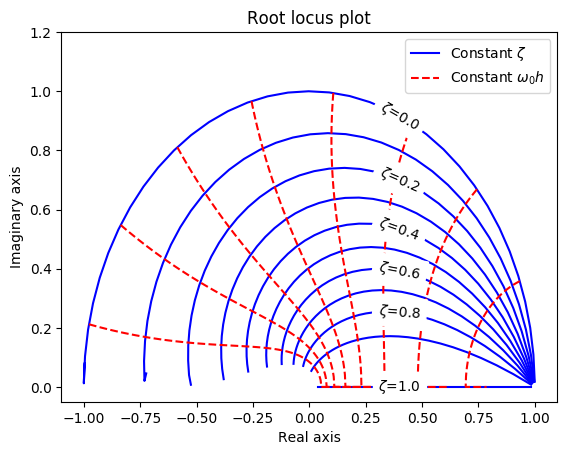

In [14]:
# note: we flip the arrays to allow for linelabelling since it assumes incremental data
lines = plt.plot(np.flip(poles_cd.T.real, 0), np.flip(poles_cd.T.imag,0), 1, color='blue')
# lines = plt.plot(poles_cd.T.real, poles_cd.T.imag, color='blue')
plt.plot(poles_cs.T.real, poles_cs.T.imag, color='red', linestyle='--')
plt.ylim(top=1.2)
plt.xlabel('Real axis')
plt.ylabel('Imaginary axis')
plt.title('Root locus plot')

# set labels
for i, line in enumerate(lines[::2]):
    labelLine(line, 0.4, label="$\zeta$=%.1f" % dampings[i*2], color='black')
    
legend_elements = [plt.Line2D([0], [0], color='b', label='Constant $\zeta$'),
                   plt.Line2D([0], [0], color='r', linestyle='--', label='Constant $\omega_0h$')]
plt.legend(handles=legend_elements, loc='upper right')

plt.show()

# Chapter 4

### Pole-placement using state feedback
If the system is reachable, there exists a linear feedback that gives a closed-loop system with the charactersitic $P(z)$. The feedback is given by:

$$
u(k) = -Lx(k)
$$

with

$$
L = (p_1-a_1,\ p_2-a_2,\ \cdots, p_n-a_n) \tilde{W}_c W_c^{-1} \\
= (0,\ \cdots\,\ 0,\ 1)W_C^{-1}P(\Phi)
$$

Where $W_c$ and $\tilde{W}_c$ are teh reachability matrices of the systems $x(k+1) = \Phi x(k) + \Gamma u(k)$ and $z(k+1) = \tilde{\Phi}z(k) + \tilde{\Gamma}u(k)$

### Example 4.2

Consider the double-integrator plant:

$$
x(k+1) = 
\begin{bmatrix}
1 & h \\
0 & 1
\end{bmatrix}
x(k) + 
\begin{bmatrix}
h^2/2 \\
h
\end{bmatrix}
u(k)
$$

In [15]:
init_printing()
h = Symbol('h')

phi = np.array([[1, h], [0, 1]])
gamma = np.array([[h**2/2], [h]])

w1 = gamma
w2 = phi.dot(gamma)
W = np.array([w1,w2]).T[0]
W = Matrix(W)
W_inv = W.inv()
W_inv

⎡-1    3 ⎤
⎢───  ───⎥
⎢  2  2⋅h⎥
⎢ h      ⎥
⎢        ⎥
⎢1    -1 ⎥
⎢──   ───⎥
⎢ 2   2⋅h⎥
⎣h       ⎦

The characteristic polynomial of the matrix $\Phi$ is $z^2-2z+1$. Hence

In [16]:
gamma = Matrix(gamma)
phi = Matrix(phi)

p1, p2 = symbols('p1 p2')
P = phi**2 + p1*phi + p2*Matrix.eye(2)
print("P=")
P

P=


⎡p₁ + p₂ + 1  h⋅p₁ + 2⋅h ⎤
⎢                        ⎥
⎣     0       p₁ + p₂ + 1⎦

Now we can use Ackermann's formula 
$$
L = (p_1-a_1,\ p_2-a_2,\ \cdots, p_n-a_n) \tilde{W}_c W_c^{-1} \\
= (0,\ \cdots\,\ 0,\ 1)W_C^{-1}P(\Phi)
$$

In [17]:
L = simplify(Matrix([0,1]).T*(W_inv)*P)
_L = L.subs([(h, 1.0), (p1, -2), (p2, -5)])

print("L=")
L

L=


⎡p₁ + p₂ + 1  p₁ - p₂ + 3⎤
⎢───────────  ───────────⎥
⎢      2          2⋅h    ⎥
⎣     h                  ⎦

We can now use $x(k+1) = \Phi x(k)- \Gamma L x(k)$ to determine the new closed loop system

In [18]:
phi_cl = phi - gamma*L
phi_cl

⎡   p₁   p₂   1     h⋅(p₁ - p₂ + 3)    ⎤
⎢ - ── - ── + ─   - ─────────────── + h⎥
⎢   2    2    2            4           ⎥
⎢                                      ⎥
⎢-(p₁ + p₂ + 1)         p₁   p₂   1    ⎥
⎢───────────────      - ── + ── - ─    ⎥
⎣       h               2    2    2    ⎦

Using this representation of the system, we can easily place the poles. For example, we want to place the poles $[p_1\ p_2] = [-2\ -5]$

Here the characteristic equation is determined using:
$$
|zI-\Phi|
$$

In [22]:
z = Symbol('z')
phi_placed = phi_cl.subs([(h, 1.0), (p1, -2.), (p2, -5.)])
collect((z*Matrix.eye(2)-phi_placed).det(), z)

# QUESTION----------------------------------------
Als ik dit goed begrijp zou de je deze methode kunnen gebruiken om de polen van een systeem te plaatsen. Dus ik zou nu $p_1$ en $p_2$ uit moeten kunnen kiezen en daarmee $L$ bepalen.
Dan zou de polen van het systeem $x(k+1) = \Phi x(k)- \Gamma L x(k)$ gelijk moeten zijn aan de gekozen $p_1$ en $p_2$. 
Alleen als ik deze methode vergelijk met die van de place command in de library komt dit niet overeen. 
Ik snap dat je met de methode in het boek de polen van de transferfunctie plaatst, en dat klopt inderdaad. 
Maar wat is het verschil tussen deze methodes.


In [23]:
#TODO figure out why new poles are incorrect

h = 1.0
p1 = -2.
p2 = -5.

phi = np.array([[1, h], [0, 1]])
gamma = np.array([[h**2/2], [h]])

l1 = 1./h**2*(1+p1+p2)
l2 = 1./(2.*h)*(3+p1-p2)
L = np.array([[l1, l2]])
G_cl = phi - gamma.dot(L)
print(G_cl)
print(np.linalg.eigvals(G_cl))

[[ 4.  -0.5]
 [ 6.  -2. ]]
[ 3.44948974 -1.44948974]


In [24]:
# Compare this result to the ctl place command
h = 1.0

Phi = np.array([[1, h], [0, 1]])
Gamma = np.array([[h**2/2], [h]])
K = ctl.place(Phi, Gamma, [-2, -5])
print(K)
FB = Phi - Gamma*K
print(FB)
print(np.linalg.eigvals(FB)) # check if poles have been placed correctly

[[ 1.80000000e+01 -3.46389584e-15]]
[[ -8.   1.]
 [-18.   1.]]
[-5. -2.]


In [25]:
# klad
from sympy import collect
h = Symbol('h')
z = Symbol('z')

phi = np.array([[1, h], [0, 1]])
gamma = np.array([[h**2/2], [h]])

gamma = Matrix(gamma)
phi = Matrix(phi)

p1, p2 = symbols('p1 p2')
l1, l2 = symbols('l1 l2')
L = Matrix([l1, l2]).T
FB_sys1 = phi - gamma*L
FB_sys2 = FB_sys1.subs([(l1, (1./(h**2))*(1.+p1+p2)), (l2, (1./(2.*h))*(3.+p1-p2))])
FB_sys3 = FB_sys2.subs([(h, 1.0), (p1, -2.), (p2, -5.)])

FB_sys1
collect((z*Matrix.eye(2)-FB_sys1).det(), z)

### Example 4.4 Choise of design parameters
Consider the double-integrator plant. Instead of using the parameters $p_1$ and $p_2$ of the characteristic equation we will introduce two other parameters, which have a more direct physical interpretation. If the desired discrete-time system is obtained by samling a second-order system with the characteristic polynomial $s^2 + 2\zeta \omega s + \omega^2 $ we find that:

$$
p_1 = -2e^{-\zeta \omega h} cos(\omega h \sqrt{1-\zeta^2}) \\
p_2 = e^{-2 \zeta \omega h}
$$

where $\omega$ is the natural frequency and $\zeta$ is teh damping. The perameter $\zeta$ influences the relative damping of the response and $\omega$ influences the response speed.  To discuss the magnitude of the control signal, it is assumed that the system has an initial position $x_0$ and an initial velocity $v_0$. The initial value of the control isgnal is then :

$$
u(0) = -l_1x_0-l_2v_0
$$

If the sampling period is short, then the expressions for p_1 and p_2 can be approximated using series expansion. The following approximation is then obtained:
$$
u(0) \approx -\omega^2x_0+2\zeta \omega v_0
$$

The expression shows that the magnitude of the control signal increases with increasing $\omega$. Thus an increase in the speed of the response of the system will require and increase in the control signals. If the bounds on the control signal and typical disturbances are known. it is possible to determine reasonable values of $\omega$. The consequences of different choises of $\omega$ when $x_0=1$ and $v_0 -1$ are illustrated in Fig. 4.2. A  larger $\omega$ givs a faster system but also larger control signals.

The selection of sampling periods for open-loop systems was discussed in Sec. 2.9. It was suggested that the sampling period can be chosen such that 

$$
N_r \approx 4-10
$$
Where $N_r$ is the number of samplers per rise time. Applying the same rule to closed-loop systems we find that the sampling period should be related to the desired behavior of the closed-loop system. It is convenient to introduce the parameter N defined by 

$$
N = \frac{2\pi}{\omega h \sqrt{1-\zeta^2}}
$$

This parameter gives the number of samples per period of dominating mode of the closed-loop system. Figure 4.3 shows the transient of the system for different values of $N$. There are small differences between the responses for $N>10$. The responses obtained for $N>20$ are indistinguishable in the graph.\\
Figure 4.3 shows the response to an initial condition when an impulse disturbance has entered the system just before the sampling. In reality the disturbances of course may enter the system at any time. With a long sampling period it will then take a long time before the disturbance is detected. To illustrate this we repeate the simulation in Fig. 4.3 but it will be assumed that the disturbance coms just after a sampling. This implies taht the disturbance acts for a full sampling period before it is detected. Figure 4.4 shows the response of the system when the system is disturbed immediately after the sampling, that is , when $x(0+) = [1\ 1]^T$. Notice the significant difference compared with Fig. 4.3. In this case the results for $N=20$ are much better than the results for $N=10$. It is reasonable to choose N in thre range $N \approx 25$ to $75$. This corresponds to $\omega h = 0.12$ to $0.36$ for $\zeta = 0.707$.

# QUESTION----------------------------------------------------
In figure 4.2 zeggen gebruiken ze ineens $\omega$ om sampling periods te beschrijven, is dit een typ fout?

### Figure 4.2


In [26]:
# Helper functions

def get_poles(zeta, omega, h=1.):
    # if h is not given, then it is assumed that omega is given as omega*h

    p1 = -2*np.exp(-zeta*omega*h)*np.cos(omega*h*np.sqrt(1-zeta**2))
    p2 = np.exp(-2*zeta*omega*h)
    return (p1, p2)
   
    

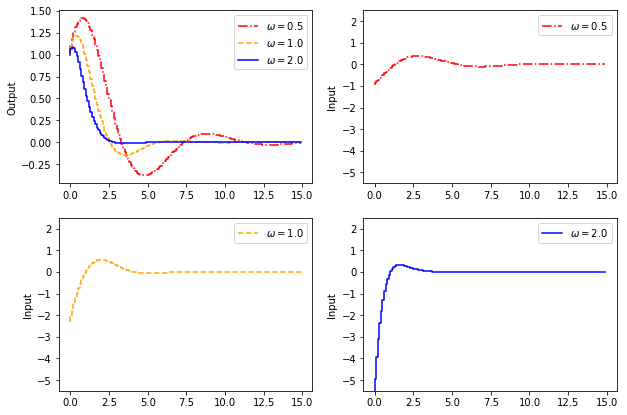

In [27]:
h = 0.1
x0 = np.array([[1],[1]])

A = np.array([[1, h], [0, 1]])
B = np.array([[h**2/2], [h]])
C = np.array([[1, 0]])
D = np.array([[0]])

fig1, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
axs = np.asarray(axs).reshape(-1)

omega_range = [0.5, 1., 2.]
linestyles = ['-.', '--', '-']
colors = ['red', 'orange', 'blue']
for i in range(len(omega_range)):
    zeta = 0.707
    omega = omega_range[i]
    
    p1, p2 = get_poles(zeta, omega, h)
    l1 = 1./h**2*(1+p1+p2)
    l2 = 1./(2.*h)*(3+p1-p2)

    L = np.array([[l1], [l2]])

    A_cl = A-B*L
    B_cl = np.array([[0], [0]])

    G_cl = ctl.ss(A_cl,B_cl,C,D, h)

    t_in = np.arange(0,15,h)
    u_in = np.zeros_like(t_in)

    t_out, y_out, x_out = ctl.forced_response(G_cl, t_in, u_in, X0=x0)
    inputs = -L.T.dot(x_out)

    # plot output
    axs[0].step(t_out, y_out[0,:], color=colors[i], linestyle=linestyles[i], label='$\omega=%.1f$' % omega)
    axs[0].set_ylabel('Output')
    axs[0].legend()

    # plot inputs
    axs[i+1].step(t_out, inputs.squeeze(), color=colors[i], linestyle=linestyles[i], label='$\omega=%.1f$' % omega)
    axs[i+1].set_ylim((-5.5,2.5))
    axs[i+1].legend()
    axs[i+1].set_ylabel('Input')
    
plt.show();

### Figure 4.3

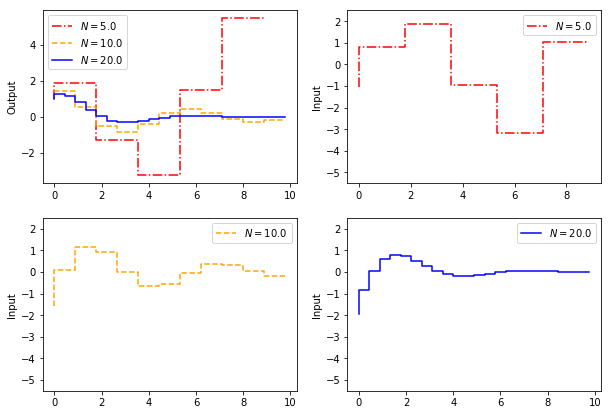

In [28]:
x0 = np.array([[1],[1]])

C = np.array([[1, 0]])
D = np.array([[0]])

fig1, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
axs = np.asarray(axs).reshape(-1)


linestyles = ['-.', '--', '-']
colors = ['red', 'orange', 'blue']

N_range = [5., 10., 20.]
for i in range(len(N_range)):
    zeta = 0.707
    omega = 1.
    N = N_range[i]
    h = (2*np.pi)/(omega*N*np.sqrt(1-zeta**2))
    
    A = np.array([[1, h], [0, 1]])
    B = np.array([[h**2/2], [h]])
    
    p1, p2 = get_poles(zeta, omega, h)
    l1 = 1./h**2*(1+p1+p2)
    l2 = 1./(2.*h)*(3+p1-p2)

    L = np.array([[l1], [l2]])

    A_cl = A-B*L
    B_cl = np.array([[0], [0]])

    G_cl = ctl.ss(A_cl,B_cl,C,D, h)

    t_in = np.arange(0,10,h)
    u_in = np.zeros_like(t_in)

    t_out, y_out, x_out = ctl.forced_response(G_cl, t_in, u_in, X0=x0)
    inputs = -L.T.dot(x_out)

    # plot output
    axs[0].step(t_out, y_out[0,:], color=colors[i], linestyle=linestyles[i], label='$N=%.1f$' % N)
    axs[0].set_ylabel('Output')
    axs[0].legend()

    # plot inputs
    axs[i+1].step(t_out, inputs.squeeze(), color=colors[i], linestyle=linestyles[i], label='$N=%.1f$' % N)
    axs[i+1].set_ylim((-5.5,2.5))
    axs[i+1].legend()
    axs[i+1].set_ylabel('Input')
    
plt.show();

### Figure 4.4
Responses of the closed-loop system in Example 4.4. The initial condition is $x^T(0+)=[1\ 1]$, and the parameter values are $\omega =1$ and $\zeta = 0.707$. 

The disturbance is immediately after the first sampling. Notice the significant difference compared to Fig. 4.3

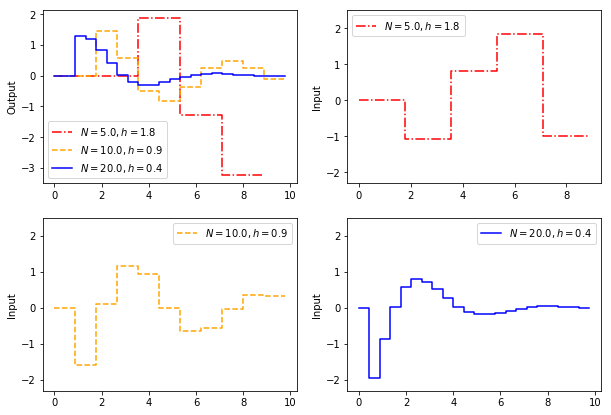

In [29]:
x0 = np.array([[1],[1]])

C = np.array([[1, 0]])
D = np.array([[0]])

fig1, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
axs = np.asarray(axs).reshape(-1)


linestyles = ['-.', '--', '-']
colors = ['red', 'orange', 'blue']

N_range = [5., 10., 20.]
for i in range(len(N_range)):
    zeta = 0.707
    omega = 1.
    N = N_range[i]
    h = (2*np.pi)/(omega*N*np.sqrt(1-zeta**2))
    
    A = np.array([[1, h], [0, 1]])
    B = np.array([[h**2/2], [h]])
    
    p1, p2 = get_poles(zeta, omega, h)
    l1 = 1./h**2*(1+p1+p2)
    l2 = 1./(2.*h)*(3+p1-p2)

    L = np.array([[l1], [l2]])

    A_cl = A-B*L
    B_cl = A_cl # this way, x(k+1) = A*(x+ex) can be simulated as A*x + B*u
    D_cl = np.array([[0, 0]]) # B and D should have same number of columns

    G_cl = ctl.ss(A_cl,B_cl,C,D_cl, h)

    t_in = np.arange(0,10,h)
    u_in = np.zeros((len(t_in),2))
    u_in[2,:] = x0.squeeze()

    t_out, y_out, x_out = ctl.forced_response(G_cl, t_in, u_in)
    inputs = -L.T.dot(x_out+u_in.T)

    # plot output
    axs[0].step(t_out, y_out[0,:], color=colors[i], linestyle=linestyles[i], label='$N=%.1f, h=%.1f$' % (N,h))
    axs[0].set_ylabel('Output')
    axs[0].legend()

    # plot inputs
    axs[i+1].step(t_out, inputs.squeeze(), color=colors[i], linestyle=linestyles[i], label='$N=%.1f, h=%.1f$' % (N,h))
    axs[i+1].set_ylim((-2.3,2.5))
    axs[i+1].legend()
    axs[i+1].set_ylabel('Input')
    
plt.show();

### Example 4.5

COnsider a double-integrator plant. it follows from (4.19) that the deadbeat control strategy is given by $u=-l_1x_1-l_2x_2$ with 
$$
l_1=\frac{1}{h^2}\quad l_2=\frac{3}{2h}
$$

If the process has the initial state $x(0)=col[x_0,v_0]$, it follows that
$$
u(0)=-\frac{x_0}{h^2}-\frac{3v_0}{2h}\quad u(h)=\frac{x_0}{h^2}+\frac{v_0}{2h}
$$

Notice that the magnitude of the control signal increases rapidly with decreasing sampling period. Also notice that for small h, the control signals $u(0)$ and $u(h)$ have opposite signs and opproximately equal magnitude. The desired effect is thus obtained as a result of subtracting two large numbers. This is further illustrated in Table 4.1, which gives the control signals for $x_0 = 1$ and $v_0 = 1$. It therefore can be expected that the deadbeat strategy is quite sensitive for small sampling periods. The output and the control signals are shown in Fig. 4.5. In this case the first sampling is at $t=0+$. The disturbance occurs immediately before the sampling.

# QUESTION -----------------------------------------------
De afbeelding komt niet geheel overeen met resultaten beneden. Bij alle afbeeldingen in het boek is de output een curve, maar met een sampling time van $h=2.0$ en een discreet systeem is dit toch niet te verwachten? Bij deze opgave heb ik interpolatie gebruikt om hem vloeiender te maken. Ook komen de responses van de vorige opgaven niet overeen. Bij afbeelding 4.2 wel. Maar bij 4.3 en 4.4, met name bij de lagere sampling rates is het systeem gewoon instabiel. Intepreteer ik hier de opgave wel goed? Ik gebruik de N waarde om de h waarde te vinden, $\omega$ en $\zeta$ zijn constant. Bij 4.3 zet ik x0 gewoon via de forced response functie. 
Bij 4.4 zet ik B_CL = A_CL zodat ik een verandering van x mee kan geven via u, bij de 2e sampling period.

### Figure 4.5

/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


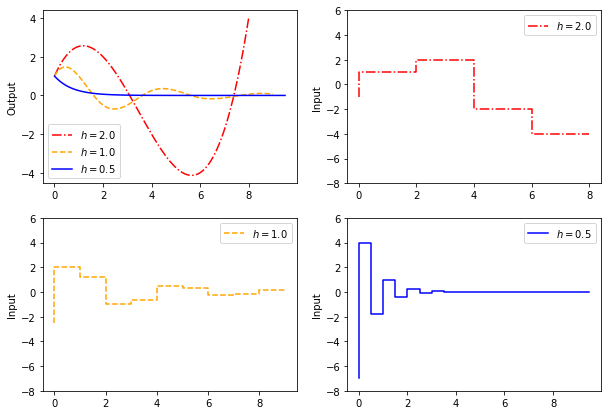

In [30]:
from scipy.interpolate import spline

x0 = np.array([[1],[1]])

C = np.array([[1, 0]])
D = np.array([[0]])

fig1, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
axs = np.asarray(axs).reshape(-1)


linestyles = ['-.', '--', '-']
colors = ['red', 'orange', 'blue']

h_range = [2., 1., 0.5]
for i in range(len(N_range)):
    zeta = 0.707
    omega = 1.
    h = h_range[i]
    
    A = np.array([[1, h], [0, 1]])
    B = np.array([[h**2/2], [h]])
    
    p1, p2 = get_poles(zeta, omega, h)
    l1 = 1./h**2
    l2 = 3./(2.*h)

    L = np.array([[l1], [l2]])

    A_cl = A-B*L
    B_cl = A_cl # this way, x(k+1) = A*(x+ex) can be simulated as A*x + B*u
    D_cl = np.array([[0, 0]]) # B and D should have same number of columns

    G_cl = ctl.ss(A_cl,B_cl,C,D_cl, h)

    t_in = np.arange(0,10,h)
    u_in = np.zeros((len(t_in),2))
#     u_in[2,:] = x0.squeeze()

    t_out, y_out, x_out = ctl.forced_response(G_cl, t_in, u_in, X0=x0)
    inputs = -L.T.dot(x_out+u_in.T)
    
    # we want a smooth output plot, so we make it
    t_new = np.linspace(t_out.min(), t_out.max(), 100)
    y_smooth = spline(t_out, y_out[0,:], t_new)
    
    # plot output
#     axs[0].plot(t_out, y_out[0,:], color=colors[i], linestyle=linestyles[i], label='$ h=%.1f$' % (h))
    axs[0].plot(t_new, y_smooth, color=colors[i], linestyle=linestyles[i], label='$ h=%.1f$' % (h))
    axs[0].set_ylabel('Output')
    axs[0].legend()

    # plot inputs
    axs[i+1].step(t_out, inputs.squeeze(), color=colors[i], linestyle=linestyles[i], label='$h=%.1f$' % (h))
    axs[i+1].set_ylim((-8, 6))
    axs[i+1].legend()
    axs[i+1].set_ylabel('Input')
    
plt.show();

### Example 4.8
